## Import Library

In [3]:
# Install rdkit

def install_rdkit():
  !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  !chmod +x Miniconda3-latest-Linux-x86_64.sh
  !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
  !time conda install -q -y -c conda-forge rdkit

# install_rdkit()

In [4]:
# Data

#from google.colab import files
import pandas as pd
import numpy as np
import regex as re

# rdkit
import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import DataStructs

# random
import random as rd

RDKit WARNING: [13:41:37] Enabling RDKit 2019.09.1 jupyter extensions


## Data

### Pre-Processing Data

In [5]:
def preprocessing_data(link_of_data) :
  dataset = pd.read_csv(link_of_data,sep=";")
  dataset = dataset.iloc[:,[0,7,9,10,11]]

  sameMol = []
  sameMolCount = {}
  dataset_handle = []

  for x in dataset.values:
    mol_name = x[0]
    if mol_name in sameMol:
      print("uye")
      x[0] = mol_name+"("+str(sameMolCount[mol_name])+")"
      sameMolCount[mol_name] += 1
    else:
      sameMol.append(x[0])
      sameMolCount[mol_name] = 1
    dataset_handle.append(x)

  #print(dataset_handle)
    
  list_of_column_dataframe = dataset.columns
  list_of_dataset_after = []

  list_of_dataset_before = np.array(dataset_handle)
  
  for data in list_of_dataset_before :
    if data[2] == "'='" :
      if data[4] == "nM" :
        if data[3] < 10000 :
          data[3] = data[3]/1000
          list_of_dataset_after.append(data)
  
  dataframe_of_dataset_after = pd.DataFrame(list_of_dataset_after)
  dataframe_of_dataset_after.columns = list_of_column_dataframe
  name_of_file_download = "Dataset_After.csv"
  dataframe_of_dataset_after.to_csv(name_of_file_download)
  #files.download(name_of_file_download)
  return dataframe_of_dataset_after



In [6]:
#preprocessing_data("https://raw.githubusercontent.com/relfarizi/Final_Project/master/Data/Dataset_Before.csv")

### Data After Pre-Processing

In [7]:
# for colab

#dataset = pd.read_csv('https://raw.githubusercontent.com/relfarizi/Final_Project/master/Data/Dataset_After.csv', index_col= 0)


dataset = pd.read_csv('Dataset_After.csv',index_col = 0)
dataset.head(5)

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units
0,CHEMBL2263120,CC1(C)CC[C@]2(C(=O)OCCCCCCCCCCC(=O)O)CC[C@]3(C...,'=',0.7200,nM
1,CHEMBL2263121,CC1(C)CC[C@]2(C(=O)NC(Cc3ccccc3)C(=O)O)CC[C@]3...,'=',3.3100,nM
2,CHEMBL168,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,'=',5.0501,nM
3,CHEMBL508831,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,'=',0.5400,nM
4,CHEMBL506556,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,'=',0.6200,nM


In [8]:
#dataset = dataset.drop_duplicates(keep=False,inplace=True)
dataset = dataset.dropna()
mol_smiles = dataset.iloc[:,1].values.tolist()
row_drop = []
for i in range(len(mol_smiles)) :
  #print(mol_smiles[i])
  if len(str(mol_smiles[i])) < 5 :
    row_drop.append(i)
print(row_drop)
dataset.drop(row_drop)
dataset.iloc[258,:]

[]


Molecule ChEMBL ID                                         CHEMBL504726
Smiles                COc1ccc(OC)c([C@@H]2O[C@H](CNC(=O)c3ccccc3)[C@...
Standard Relation                                                   '='
Standard Value                                                     4.13
Standard Units                                                       nM
Name: 258, dtype: object

## Probability Activity

### 1. Molecule Activity
Untuk mencari jumlah dari nilai aktivitas masing2 molekul

variabel yang digunakan :
* mol_name = list nama molekul
* mol_smile = list smile molekul
* mol_act = list berisi nilai IC50
* act = nilai aktivitas tiap molekul
* sum_act = Nilai jumlah dari a

In [9]:
mol_name = dataset.iloc[:,0].values.tolist()
mol_smiles = dataset.iloc[:,1].values.tolist()
mol_act = dataset.iloc[:,3].values.tolist()
sum_act = 0
for molekul in mol_act :
  act = np.exp(-molekul)
  sum_act  += act
print(sum_act)

616.3006027743246


### 2. Probability Succes


Mencari nilai probabilitas kesuksesan untuk setiap molekul

Variabel yang digunakan :
* n = banyaknya molekul
* mol_prob = list probabilitas setiap molekul
* act = nilai aktivitas molekul
* prob = nilai probabilitas kesuksesan molekul
* sum_pro = nilai jumlah dari Probabiliras Kesuksesan




In [10]:
n = len(mol_act)
#p_avg = 1/n
mol_prob = []

# act = probabilitas kesuksesan

sum_pro = 0
for molekul in mol_act :
  #act = (molekul[1]*p_avg*n)/sum_act
  act = np.exp(-molekul)
  prob = act/sum_act
  prob = round(prob,8)
  mol_prob.append(prob)
  sum_pro += prob
print(sum_pro)


0.9999999799999977


## Cost (Trial)

Menentukan cost dari setiap molekul. cell ini baru coba di-generate hanya dengan mengalikan dengan sum_of_cost dengan probability kesuksesannya. sehingga nilai probabilitas terbesar diasumsikan memiliki cost yang besar pula

In [11]:
sum_of_cost = 500000
mol_cost = []
sum_cost = 0
for mol in mol_prob:
    cost = mol*sum_of_cost
    mol_cost.append(round(cost,4))
    sum_cost += cost
print(sum_cost)

499999.99000000075


## Fingerprint

berisi bit biner dari sifat yang menggambarkan suatu molekul (baca lagi)

Variabel yang digunakan :
* fingerprint suatu molekul (dalam bit biner)
* mol_fp = list dari fingerprint setiap molekul


In [12]:
mol_fp = []
i = 0
print(mol_smiles[258])
for molekul in mol_smiles :
  smiles = Chem.MolFromSmiles(str(molekul))
  fp = Chem.RDKFingerprint(smiles)
  #print(i)
  i+= 1
  mol_fp.append(fp)
print((mol_fp))

E630E28490>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E284E0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28530>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28580>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E285D0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28620>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28670>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E286C0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28710>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28760>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E287B0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28800>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001E630E28850>, <rdkit.DataStructs.cDataStructs.Explici

## To DataFrame

In [13]:
#df_mol = pd.DataFrame.from_dict(mol_act_dict, orient='index')
#df_mol.columns = ["IC50","Molecule Activity", "Probability Activity"]
#df_mol.sort_values(by=["IC50"], ascending=False)
#mol_name = pd.Series(mol_name)
#mol_act = pd.Series(mol_act)
#df_mol = pd.concat(mol_name,mol_act)
#print(len(mol_name))
#print(len(mol_smiles))
#print(len(mol_fp))
#print(len(mol_act))
#print(len(mol_prob))

df = pd.DataFrame({'mol_name':mol_name,
                       'mol_smiles' : mol_smiles,
                       'mol_act':mol_act,
                       'mol_fp' : mol_fp,
                       'mol_prob' : mol_prob,
                       'mol_cost' : mol_cost
                       })

df.head()

,mol_name,mol_smiles,mol_act,mol_fp,mol_prob,mol_cost
0,CHEMBL2263120,CC1(C)CC[C@]2(C(=O)OCCCCCCCCCCC(=O)O)CC[C@]3(C...,0.7200,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.000790,394.900
1,CHEMBL2263121,CC1(C)CC[C@]2(C(=O)NC(Cc3ccccc3)C(=O)O)CC[C@]3...,3.3100,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...",0.000059,29.625
2,CHEMBL168,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,5.0501,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.000010,5.200
3,CHEMBL508831,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,0.5400,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.000946,472.780
4,CHEMBL506556,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,0.6200,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.000873,436.430


In [14]:
df_mol = df.iloc[:,[0,2,3,5]]
df_mol

,mol_name,mol_act,mol_fp,mol_cost
0,CHEMBL2263120,0.7200,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",394.900
1,CHEMBL2263121,3.3100,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...",29.625
2,CHEMBL168,5.0501,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",5.200
3,CHEMBL508831,0.5400,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",472.780
4,CHEMBL506556,0.6200,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",436.430
...,...,...,...,...
1847,CHEMBL1782241,5.2000,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, ...",4.475
1848,CHEMBL323197,5.5000,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...",3.315
1849,CHEMBL4071698,0.7200,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",394.900
1850,CHEMBL3770020,1.5800,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",167.105


## Individu
suatu fungsi yang bertujuan untuk me-return dari suatu populasi (kumpulan individu berdasarkan subset yang diberikan). 

return :
* mol_name
* rata-rata dari act
* rata-rata dari mol_fp

cara menyari diversity :

dengan menghitung semua similarity antar molekul kemudian hasilnya di rata2kan

sebagai contoh :

ada 3 (subset) molekul (A,B,C), maka menghitungnya

* A -> B
* A -> C
* B -> C

kemudian dirata2kan

In [15]:
n_subset = 5

def individu(subset):
    #subset = np.array(subset.values.tolist())
    mol_name = subset.iloc[:,0].values
    mol_act = subset.iloc[:,1].values
    mol_fp = subset.iloc[:,2].values
    #print(mol_name)
    #print(mol_act)
    #print(mol_fp[1])

    
    fp_list = []
    n = len(subset)
    
    for i in range(n):
        for j in range(n):
            if i > j :
                tmp_fp = DataStructs.FingerprintSimilarity(mol_fp[i],mol_fp[j])
                fp_list.append(tmp_fp)
                
    avg_act = np.mean(mol_act)
    avg_div = np.mean(fp_list)
    
    if [mol_name,avg_act,avg_div] is not None :
        return [mol_name,avg_act,avg_div]
    else :
        return []



### cek budget

mengecek apakah molekul yang terpilih (yang ada di subset) tidak melebihi budget yang diberikan

In [16]:
def is_budget_enough(subset,budget):
    subset =  subset.iloc[:,3].values
    sum_of_subset = np.sum(subset)
    if sum_of_subset <= budget :
        check = True
    else :
        check = False
    return [check,sum_of_subset]

### NSGA-II

#### Initialization Individu

Menginisialisasi individu yang akan digunakan berdasarkan subset yang ada

In [17]:
# Initialization of Individu
budget = 5000
n_subset = 20

def initialization_individu(df_mol,budget,n_subset) :
    i = 0
    iteration = 100
    calon_individu = df_mol.sample(n_subset)

    while(not is_budget_enough(calon_individu,budget)[0]) and i < iteration :
        calon_individu = df_mol.sample(n_subset)
        i+=1
    if is_budget_enough(calon_individu,budget)[0]:
        return individu(calon_individu)
    else :
        return []

        
        

In [18]:
if initialization_individu(df_mol,budget,n_subset) != [] :
    print(initialization_individu(df_mol,budget,n_subset))
else :
    print("can't continue")

[array(['CHEMBL1783775(1)', 'CHEMBL504397(2)', 'CHEMBL4078186',
       'CHEMBL3098853', 'CHEMBL276376', 'CHEMBL3427131', 'CHEMBL516014',
       'CHEMBL2424661(1)', 'CHEMBL3350943', 'CHEMBL1938823',
       'CHEMBL1164945', 'CHEMBL278096', 'CHEMBL1783789', 'CHEMBL267759',
       'CHEMBL556913', 'CHEMBL2063152', 'CHEMBL1778901', 'CHEMBL1162226',
       'CHEMBL3350944', 'CHEMBL380467'], dtype=object), 2.422885, 0.29527774178774113]


In [19]:
ind = initialization_individu(df_mol,budget,n_subset)
print(ind[0])

['CHEMBL193233(1)' 'CHEMBL301567' 'CHEMBL510225(1)' 'CHEMBL9363'
 'CHEMBL4069413' 'CHEMBL193134(1)' 'CHEMBL1778901' 'CHEMBL403577'
 'CHEMBL3088258' 'CHEMBL2263119(1)' 'CHEMBL556914' 'CHEMBL1935491'
 'CHEMBL4064802' 'CHEMBL3402414' 'CHEMBL169(25)' 'CHEMBL426373(5)'
 'CHEMBL204337' 'CHEMBL57391' 'CHEMBL314412' 'CHEMBL1935609']


In [20]:
coba = df_mol.iloc[:,:]
ls = []
dict_cek ={}
for i in coba.values:
    if i[0] in dict_cek.keys():
        dict_cek[i[0]] +=1
    else :
        dict_cek[i[0]] =1
    #print(i[0])
    ls.append(i.tolist())
#pd.DataFrame(ls)
sum = 0
sum_ = 0
for x in dict_cek:
    if dict_cek[x] > 1 :
        sum += 1
        sum_ += dict_cek[x]
print("nama molekul sama =",sum,"jumlah molekul yang sama =",sum_)
#print(dict_cek)

nama molekul sama = 0 jumlah molekul yang sama = 0


### Mutation

In [21]:
def mutation(indvd,df_mol) :
    #print(type(individu))
    #individu =df_ind.tolist()
    # 1. deleting a single randomly choosen molecule
    inDltd = rd.choice(indvd[0])
    # 2. Adding a randomly choosen new molecule
    molecule = df_mol["mol_name"].tolist()
    inAdd = rd.choice(molecule)

    # 3. replacing a molecule inside the portfolio by a molecule outside portfolio
    inNew = indvd[0].tolist()
    inNew.remove(inDltd)
    inNew.append(inAdd)
    column = df_mol.columns
    inNewLst = []
    for data in df_mol.values:
        if data[0] in inNew :
            inNewLst.append(data)
    print(len(inNewLst))
    df_new = pd.DataFrame(inNewLst)
    df_new.columns = column
    #print(type(df_new))
    
    max_iter = 1000
    iter = 0
    while(iter < max_iter) :
        if is_budget_enough(df_new,budget)[0] :
            return individu(df_new)
            break
        iter += 1
        
    else :
        print(iter)
        return []

print(len(ind[0]))
print(ind)
ind2 = (mutation(ind,df_mol))
#print(is_budget_enough(mutation(ind[0],df_mol),budget))


20
[array(['CHEMBL193233(1)', 'CHEMBL301567', 'CHEMBL510225(1)', 'CHEMBL9363',
       'CHEMBL4069413', 'CHEMBL193134(1)', 'CHEMBL1778901',
       'CHEMBL403577', 'CHEMBL3088258', 'CHEMBL2263119(1)',
       'CHEMBL556914', 'CHEMBL1935491', 'CHEMBL4064802', 'CHEMBL3402414',
       'CHEMBL169(25)', 'CHEMBL426373(5)', 'CHEMBL204337', 'CHEMBL57391',
       'CHEMBL314412', 'CHEMBL1935609'], dtype=object), 3.0331889999999997, 0.3046866397682243]
20


### Non Dominated Sorted


In [22]:
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front



In [38]:
nPortfolio = 5
nSubset = 5
fMaxObj1 = []
fMaxObj2 = []
solution = []
for i in range(nPortfolio) :
    portfolio = initialization_individu(df_mol,budget,nSubset)
    solution.append(portfolio[0])
    fMaxObj1.append(portfolio[1]) # Probabilitas Kesuksesan
    fMaxObj2.append(portfolio[2]) # Diversity   
    

In [39]:
fast_non_dominated_sort(fMaxObj1,fMaxObj2)

[[1, 2, 4], [0], [3]]

In [49]:
import math
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list


In [50]:
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

In [51]:
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

In [52]:

#Main program starts here
pop_size = 7 # ini banyaknya individu dalam 1 populasi (subset kata pak isman mah)
max_gen = 50

#Initialization
min_x=-55
max_x=55

# Ini kayanya buat bikin solusi individu (0 atau 1)
#solution=[round(min_x+(max_x-min_x)*random.random(),3) for i in range(0,pop_size)] # Portofolio 
#print("sol",solution) # --> [-51.492, -31.654, -47.084, -11.823, 41.043]

gen_no=0


while(gen_no<max_gen):
    function1_values = fMaxObj1 # Kumpulan function 1 dari 1 portofolio
    function2_values = fMaxObj2# Kumpulan function 2 dari 1 portofolio
    print("f1v",function1_values) # --> [-2651.4260639999998, -1001.975716, -2216.903056, -139.783329, -1684.5278489999998]
    print("f2v",function2_values) # -->  [-2861.3940639999996, -1132.5917159999997, -2409.2390560000003, -191.075329, -1524.355849]
    
    non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:],function2_values[:])
    print("non-dominated",non_dominated_sorted_solution)
    print("The best front for Generation number ",gen_no, " is")
    
    for valuez in non_dominated_sorted_solution[0]:
        print("valuez",valuez,solution[valuez],end=" ")
    print("\n")
    crowding_distance_values=[]
    
    
    for i in range(0,len(non_dominated_sorted_solution)):
        crowding_distance_values.append(crowding_distance(function1_values[:],function2_values[:],non_dominated_sorted_solution[i][:]))
    solution2 = solution[:]
    
    
    
    #Generating offsprings

    # sementara pake random dulu
    """
    while(len(solution2)!=2*pop_size):
        a1 = random.randint(0,pop_size-1)
        b1 = random.randint(0,pop_size-1)
        solution2.append(crossover(solution[a1],solution[b1]))
        
    """    
    
        
    function1_values2 = [function1(solution2[i])for i in range(0,2*pop_size)]
    function2_values2 = [function2(solution2[i])for i in range(0,2*pop_size)]
    non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:],function2_values2[:])
    print("non-dominated sorteed =",non_dominated_sorted_solution2)
    """
        Hasil dari non_domiated_sorted
        
        From :
        [[0, 5], [1], [2], [3, 4], [6], [9], [7], [8]]

        to :

        [[0, 1, 2, 3, 4], [6], [9], [5], [7], [8]]
    
    """
    crowding_distance_values2=[]
    
    
    
    for i in range(0,len(non_dominated_sorted_solution2)):
        crowding_distance_values2.append(crowding_distance(function1_values2[:],function2_values2[:],non_dominated_sorted_solution2[i][:]))
    new_solution= []
    
    
    for i in range(0,len(non_dominated_sorted_solution2)):
        non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
        front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front.reverse()
        
        
        for value in front:
            new_solution.append(value)
            
            if(len(new_solution)==pop_size):
                break
                
        if (len(new_solution) == pop_size):
            break
            
    # update solution
    solution = [solution2[i] for i in new_solution]
    gen_no = gen_no + 1

f1v [2.586, 2.49, 4.5236979999999996, 2.332, 5.4494]
f2v [0.27188426587744285, 0.3357729240807005, 0.32279801866942537, 0.2342112858898162, 0.3116429361028151]
non-dominated [[1, 2, 4], [0], [3]]
The best front for Generation number  0  is
valuez 1 ['CHEMBL370140' 'CHEMBL3234648' 'CHEMBL2262836(1)' 'CHEMBL3394773'
 'CHEMBL599257'] valuez 2 ['CHEMBL443007' 'CHEMBL3310443' 'CHEMBL1801404' 'CHEMBL284363(1)'
 'CHEMBL211990'] valuez 4 ['CHEMBL464651' 'CHEMBL168(10)' 'CHEMBL168(20)' 'CHEMBL1242363'
 'CHEMBL3219584'] 



NameError: name 'random' is not defined

In [40]:
def nonDominatedsorted(p,q) :
    
    budget = 5000
    n_subset = 5

    # Fungsi buat Dominance test

    def isDominated(p,q): # success !!

        fObj1 = {"p": p[1], "q" : q[1]}
        fObj2 = {"p": p[2], "q" : q[2]}
        if fObj1["p"] > fObj1["q"] or fObj2["p"] > fObj2["q"] :
            return True
        else :
            return False
    """
    if isDominated(p,q):
        return [[p[1],q[1]],[p[2],q[2]]]
    else :
        return "Not uye"
    """

    # Fungsi buat Inisialisasi individu (Masih Random)

    def initialization_individu(df_mol,budget,n_subset) :
        i = 0
        iteration = 100
        calon_individu = df_mol.sample(n_subset)

        while(not is_budget_enough(calon_individu,budget)[0]) and i < iteration :
            calon_individu = df_mol.sample(n_subset)
            i+=1
        if is_budget_enough(calon_individu,budget)[0]:
            return individu(calon_individu)
        else :
            return []
    
    """ --- Start Non Dominated Sorted --- """

    Sp = []
    np = 0
    
    # Inisialisasi q

    q = initialization_individu(df_mol,budget,n_subset)

nonDominatedsorted(ind,ind2) 



### Try Pymoo

In [363]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt5")

print(problem)

algorithm = NSGA2(pop_size=100,
                  sampling=get_sampling("bin_random"),
                  crossover=get_crossover("bin_two_point"),
                  mutation=get_mutation("bin_bitflip"),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 500),
               seed=1,
               verbose=True)

print(res)


  | 17400   | 0.0346606260 | 0.0330232870 | 0.8544639539
175   | 17500   | 0.0346606260 | 0.0336564633 | 0.8544639539
176   | 17600   | 0.0346606260 | 0.0339003063 | 0.8544639539
177   | 17700   | 0.0346606260 | 0.0339370820 | 0.8544639539
178   | 17800   | 0.0346606260 | 0.0349496790 | 0.8544639539
179   | 17900   | 0.0346606260 | 0.0350604661 | 0.8544639539
180   | 18000   | 0.0346606260 | 0.0354691853 | 0.8544639539
181   | 18100   | 0.0346606260 | 0.0361976592 | 0.8544639539
182   | 18200   | 0.0346606260 | 0.0363128766 | 0.8544639539
183   | 18300   | 0.0346606260 | 0.0350975757 | 0.8544639539
184   | 18400   | 0.0346606260 | 0.0329168305 | 0.8544639539
185   | 18500   | 0.0346606260 | 0.0344034038 | 0.8544639539
186   | 18600   | 0.0346606260 | 0.0350984957 | 0.8544639539
187   | 18700   | 0.0346606260 | 0.0336898798 | 0.8544639539
188   | 18800   | 0.0346606260 | 0.0336059297 | 0.8544639539
189   | 18900   | 0.0346606260 | 0.0329664851 | 0.8544639539
190   | 19000   | 0.03466062

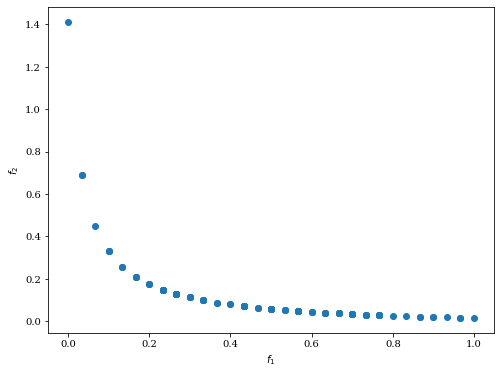

In [38]:
Scatter().add(res.F).show()

## For git (Can't be use yet)

file > save a copy in Github

In [0]:
#!git init

#!git config --global user.name “relfarizi”

#!git remote add origin https://github.com/relfarizi/Final_Project.git

#!git add .

#!git commit -m "Probability Activity"

#!git push

#!git status

### lampau

In [0]:
subset_row = []
sum_of_subset = 10

for i in range(sum_of_subset):
    random = rd.randint(0,len(df_mol))
    while random in subset_row:
        random = rd.randint(0,len(df_mol))
    subset_row.append(random)
    
print(subset_row)
calon_individu = df_mol.iloc[subset_row,:].values.tolist()
calon_individu

individu(calon_individu)

In [0]:
# Inisialisasi Individu

def initialization_individu() :
    for i in range(sum_of_subset):
        random = rd.randint(0,len(df_mol))
        while random in subset_row:
            random = rd.randint(0,len(df_mol))
        subset_row.append(random)
#subset_row = rd.sample(df_mol.values,10)
df
list_subset = []
for i in (df_mol).index :
    if i in subset_row:
        is_subset = 1
    else :
        is_subset = 0
    list_subset.append(is_subset)
print(list_subset)